In [295]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [296]:
# usando as unidades de medida do SI
C = 100 * 10**-12
G_L, E_L = 10 * 10**-9, -70 * 10**-3
G_Na, E_Na = 3.6 * 10**-6, 55 * 10**-3
G_K, E_K = 1.6 * 10**-6, -90 * 10**-3
G_T, E_Ca = 0.22 * 10**-6, 120 * 10**-3

# valores iniciais
v0, h0, n0, h_t0 = -0.070, 0.89619, -0.06208, 1/(1+np.exp(3))

# valor em V em que ocorre potencial de acao
valor_spike = -0.03

In [297]:
# variaveis de gating
def alpham(V):
    if V == (-0.035):
        return 10**3 / np.exp(-100*(V+0.035))
    else:
        return (10**5 * (V+0.035)) / (1 - np.exp(-100*(V+0.035)))
def alphan(V):
    if V == (-0.034):
        return (5 * 10**2) / np.exp(-100*(V+0.034))
    else:
        return (5 * 10**4 * (V+0.034)) / (1 - np.exp(-100*(V+0.034)))

def alphah(V): return 350*np.exp(-50*(V+0.058))

def betam(V): return 4000*np.exp(-(V+0.06)/0.018)
def betan(V): return 625*np.exp(-12.5*(V+0.044))
def betah(V): return 5000 / (1 + np.exp(-100*(V+0.028)))

def m_i(V): return alpham(V) / (alpham(V) + betam(V))
def m_ti(V): return 1 / (1+np.exp(-(V+0.052) / 0.0074))
def h_ti(V): return 1 / (1+np.exp(500*(V+0.076)))

def t_ht(V):
    if V>=(-0.080):
        return 0.028 + 0.001*np.exp(-(V+0.022) / 0.0105)
    else:
        return 0.001*np.exp(15*(V+0.467))

In [298]:
t = np.arange(0, 0.750, 0.00001)    # valores de tempo
num_spikes = 0  # variavel para o numero de disparos

In [299]:
# corrente injetada
def J_inj(t):
    J_base = (30) * 10**-12
    J_degrau = (33) * 10**-12
    J_soma = J_base + J_degrau
    ti_base = 0
    tf_base = 0.250
    ti_degrau = 0.250
    tf_degrau = 0.500
    return J_base*(t>=ti_base)-J_base*(t>tf_base)+J_soma*(t>ti_degrau)-J_soma*(t>tf_degrau)+J_base*(t>0.500)


# equacoes do modelo
def dALLdt(X,t):
    V, h, n, h_t = X
    dVdt = (J_inj(t) - G_L*(V-E_L) - G_Na * m_i(V)**3 * h*(V-E_Na) - G_K * n**4 * (V-E_K) - G_T * m_ti(V)**2 * h_t*(V-E_Ca)) / C
    dhdt = alphah(V)*(1-h) - betah(V) * h
    dndt = alphan(V)*(1-n) - betan(V) * n
    dh_tdt = (h_ti(V) - h_t) / t_ht(V)

    return dVdt, dhdt, dndt, dh_tdt

In [300]:
# solucao das equacoes
X = odeint(dALLdt, [v0, h0, n0, h_t0], t)
V = X[:,0]
h = X[:,1]
n = X[:,2]
h_t = X[:,3]

In [301]:
# loop para calcular o numero de disparos
for i in range(len(V)-1):
    if V[i]<valor_spike and V[i+1]>valor_spike:
        num_spikes += 1

# frequencia de disparos em Hz
frequencia = (num_spikes / 0.750)

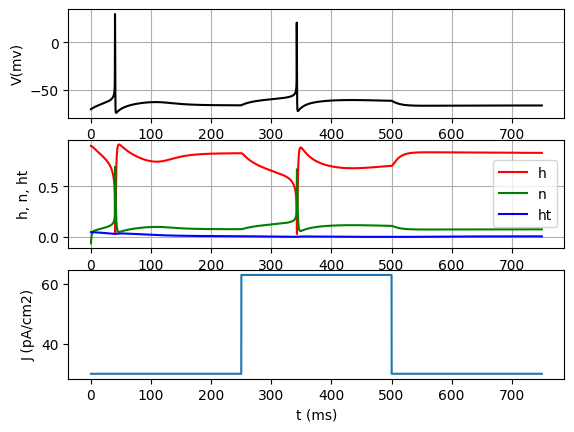

In [302]:
# graficos
plt.subplot(3,1,1)
plt.plot(t*1000, V*1000, 'k')
plt.grid(True)
plt.ylabel('V(mv)')

plt.subplot(3,1,2)
plt.plot(t*1000, h, 'r', label='h')
plt.plot(t*1000, n, 'g', label='n')
plt.plot(t*1000, h_t, 'b', label='ht')
plt.ylabel('h, n, ht')
plt.grid(True)
plt.legend()

plt.subplot(3,1,3)
plt.plot(t*1000, J_inj(t) * 10**12)
plt.xlabel('t (ms)')
plt.ylabel('J (pA/cm2)')

plt.show()